Epoch 1/100


C:\Users\adars\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.4104
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.3963
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3826
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3695
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3569
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3448
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.3332
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.3221
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3114
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.3012
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2915
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.2823
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2735
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2652
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2574
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━

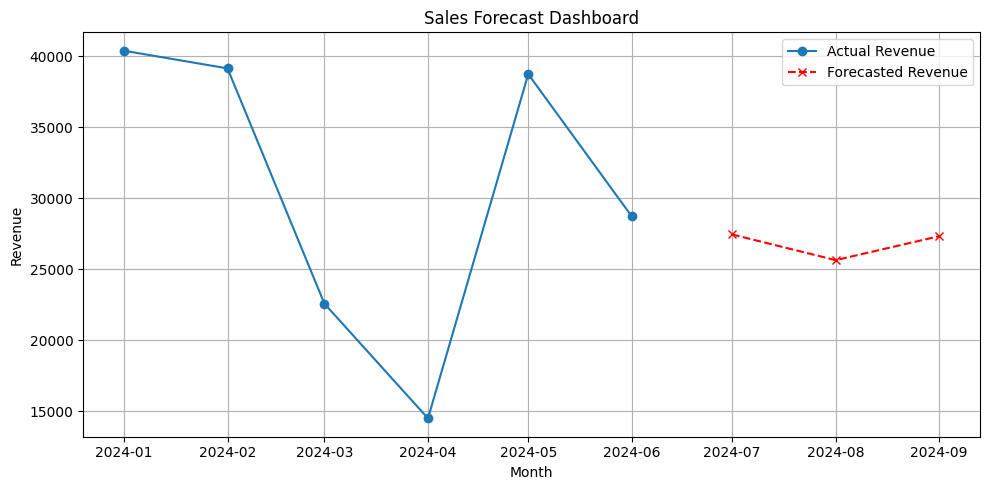

In [5]:
# === Step 1: Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# === Step 2: Load and Preprocess the Data ===
df = pd.read_csv("C:\\Users\\adars\\OneDrive\\Desktop\\shashank\\Data\\sales data\\sales_data.csv")  # Use your actual CSV path
df['Date'] = pd.to_datetime(df['Date'])
df['Revenue'] = df['Quantity'] * df['Price']
df['Month'] = df['Date'].dt.to_period('M')

# Group by month to get total revenue
monthly_revenue = df.groupby('Month')['Revenue'].sum().reset_index()
monthly_revenue['Month'] = monthly_revenue['Month'].dt.to_timestamp()

# === Step 3: Normalize and Create Sequences ===
data = monthly_revenue['Revenue'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

def create_sequences(data, window_size=3):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, window_size=3)
X = X.reshape((X.shape[0], X.shape[1], 1))

# === Step 4: Build and Train the LSTM Model ===
model = Sequential()
model.add(LSTM(64, input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=100, verbose=1)

# === Step 5: Forecast Next 3 Months ===
last_seq = scaled_data[-3:].reshape(1, 3, 1)
forecast = []

for _ in range(3):
    pred = model.predict(last_seq)[0]
    forecast.append(pred)
    last_seq = np.append(last_seq[:, 1:, :], [[pred]], axis=1)

forecasted_revenue = scaler.inverse_transform(forecast).flatten()

# === Step 6: Prepare Forecast DataFrame ===
last_month = monthly_revenue['Month'].iloc[-1]
forecast_months = pd.date_range(start=last_month + pd.offsets.MonthBegin(1), periods=3, freq='MS')

forecast_df = pd.DataFrame({
    'Month': forecast_months,
    'Revenue': forecasted_revenue
})

# === Step 7: Plot Actual vs Forecasted Revenue ===
plt.figure(figsize=(10, 5))
plt.plot(monthly_revenue['Month'], monthly_revenue['Revenue'], marker='o', label="Actual Revenue")
plt.plot(forecast_df['Month'], forecast_df['Revenue'], marker='x', linestyle='--', color='red', label="Forecasted Revenue")
plt.title("Sales Forecast Dashboard")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Step 8: Export to CSV for Tableau ===
combined_df = pd.concat([monthly_revenue, forecast_df])
combined_df.to_csv("sales_forecast_output.csv", index=False)
